In [1]:
%pylab inline
import numpy as np
import gym
from gym import spaces
import warnings
warnings.filterwarnings("ignore")

Populating the interactive namespace from numpy and matplotlib


In [2]:
class AgentEnv(gym.Env):
    metadata = {
        'render.modes': ['human']
    }
    def __init__(self):
        self.T_min = 20
        self.T_max = 80
        self.T = self.T_max - self.T_min
        self.reset()
        
        self.action_space = spaces.Box(
            low=1,
            high=self.state[1],
            shape = (1,),
            dtype=np.float32
        )
        self.observation_space = spaces.Box(
            low=0,
            high=1000,
            shape = (2,),
            dtype=np.float32
        )
        self.reset()
     
    def u(self,c):
        gamma = 2
        return (np.float_power(c, 1-gamma) - 1)/(1 - gamma)
    
    def step(self, action):
        c = action
        r = 0.02
        done = bool(
            self.state[0] == self.T_max-1
        )
        self.state[0] += 1
        
        c = action
        if done:
            reward = 2*self.u(c)
        else:
            reward = self.u(c)
            
        self.state[1] = (self.state[1] - c)*(1+r)
        
        return self.state, reward, done, {}
    
    def reset(self):
        self.age = self.T_min
        self.state = np.array([self.T_min,np.random.randint(60,80)])
        return np.array(self.state)
    
    def render(self):
        plt.plot(self.state[0], self.state[1], 'ro')

Model: "model1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense (Dense)                (None, 4)                 12        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 17
Trainable params: 17
Non-trainable params: 0
_________________________________________________________________
episode: 0/17, e: 1.0
episode: 1/17, e: 1.0
episode: 2/17, e: 1.0
episode: 3/17, e: 1.0
episode: 4/17, e: 1.0
episode: 5/17, e: 1.0
episode: 6/17, e: 1.0
episode: 7/17, e: 1.0
episode: 8/17, e: 1.0
episode: 9/17, e: 1.0
episode: 10/17, e: 1.0
episode: 11/17, e: 1.0
episode: 12/17, e: 1.0
episode: 13/17, e: 1.0
episode: 14/17, e: 1.0
episode: 15/17, e: 1.0
episode: 16/17, e: 0.98
Saving train

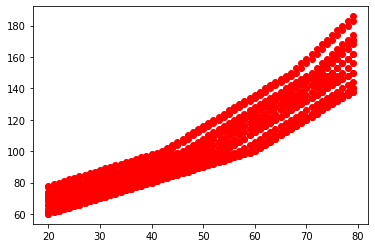

In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
import random
from collections import deque
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.optimizers import Adam, RMSprop


def OurModel(input_shape, action_space):
    X_input = Input(input_shape)

    # 'Dense' is the basic form of a neural network layer
    X = Dense(4, input_shape=input_shape, activation="relu", kernel_initializer='he_uniform')(X_input)

    # Output Layer with # of actions: 2 nodes (left, right)
    X = Dense(action_space, activation="linear", kernel_initializer='he_uniform')(X)

    model = Model(inputs = X_input, outputs = X, name='model1')
    
    model.compile(loss="mse", optimizer=RMSprop(lr=0.00025, rho=0.95, epsilon=0.01), metrics=["accuracy"])

    model.summary()
    return model

class DQNAgent:
    def __init__(self):
        self.env = AgentEnv()
        self.state_size = self.env.observation_space.shape[0]
        self.action_size = self.env.action_space.shape[0]
        self.EPISODES = 20
        self.memory = deque(maxlen=2000)
        
        self.gamma = 1/(1+0.02)    # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.001
        self.epsilon_decay = 0.999
        self.batch_size = 64
        self.train_start = 1000

        # create main model
        self.model = OurModel(input_shape=(self.state_size,), action_space = self.action_size)

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        if len(self.memory) > self.train_start:
            if self.epsilon > self.epsilon_min:
                self.epsilon *= self.epsilon_decay

    def act(self, state):
        if np.random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        else:
            return np.argmax(self.model.predict(state))

    def replay(self):
        if len(self.memory) < self.train_start:
            return
        # Randomly sample minibatch from the memory
        minibatch = random.sample(self.memory, min(len(self.memory), self.batch_size))

        state = np.zeros((self.batch_size, self.state_size))
        next_state = np.zeros((self.batch_size, self.state_size))
        action, reward, done = [], [], []

        # do this before prediction
        # for speedup, this could be done on the tensor level
        # but easier to understand using a loop
        for i in range(self.batch_size):
            state[i] = minibatch[i][0]
            action.append(minibatch[i][1])
            reward.append(minibatch[i][2])
            next_state[i] = minibatch[i][3]
            done.append(minibatch[i][4])

        # do batch prediction to save speed
        target = self.model.predict(state)
        target_next = self.model.predict(next_state)

        for i in range(self.batch_size):
            # correction on the Q value for the action used
            if done[i]:
                target[i][action[i]] = reward[i]
            else:
                # Standard - DQN
                # DQN chooses the max Q value among next actions
                # selection and evaluation of action is on the target Q Network
                # Q_max = max_a' Q_target(s', a')
                target[i][action[i]] = reward[i] + self.gamma * (np.amax(target_next[i]))

        # Train the Neural Network with batches
        self.model.fit(state, target, batch_size=self.batch_size, verbose=0)


    def load(self, name):
        self.model = load_model(name)

    def save(self, name):
        self.model.save(name)
            
    def run(self):
        for e in range(self.EPISODES):
            state = self.env.reset()
            state = np.reshape(state, [1, self.state_size])
            done = False
            while not done:
                self.env.render()
                action = self.act(state)
                next_state, reward, done, _ = self.env.step(action)
                next_state = np.reshape(next_state, [1, self.state_size])
                self.remember(state, action, reward, next_state, done)
                state = next_state
                if done:                   
                    print("episode: {}/{}, e: {:.2}".format(e, self.EPISODES, self.epsilon))
                self.replay()
                
        print("Saving trained model as model")
        self.save("./model.tf")
        return
    
    def test(self):
        self.load("./model.tf")
        for e in range(3):
            state = self.env.reset()
            state = np.reshape(state, [1, self.state_size])
            done = False
            while not done:
                self.env.render()
                action = np.argmax(self.model.predict(state))
                next_state, reward, done, _ = self.env.step(action)
                state = np.reshape(next_state, [1, self.state_size])
                if done:
                    print("episode: {}/{} ".format(e, self.EPISODES))
                    break

agent = DQNAgent()
agent.run()
# agent.test()

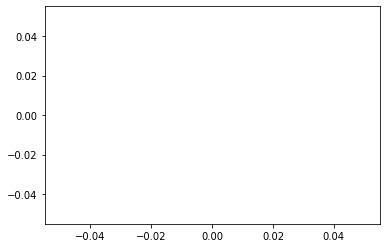

In [4]:
states = np.stack((np.linspace(20,80,61), np.ones(61)*100), axis = -1)
plt.plot(states[:,0], agent.model.predict(states)[:,0])

In [5]:
agent.model.predict(states)

array([[nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan]], dtype=float32)